---

<div align=center>

# **Initialisation**

</div>

### Environment

In [4]:
!nvidia-smi

Tue Mar 28 11:03:33 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     On   | 00000000:3B:00.0 Off |                    0 |
| N/A   24C    P8    21W / 250W |      0MiB / 22698MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!nvcc --version

/bin/bash: line 1: nvcc: command not found


In [6]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dependencies

In [29]:
import numpy as np
import tensorflow as tf
from LRFutils import archive, progress
from multiprocess import Pool, cpu_count
import psutil
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy as copy

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Configuration

In [9]:
valid_frac = 0.2
test_frac  = 0.1
dataset_path = "data/dataset"

### Global variables

In [10]:
archive_path = archive.new()

try:
    ncpu = cpu_count()
except:
    with open(os.getenv("OAR_NODEFILE"), 'r') as f:
        ncpu = len(f.readlines())

def is_notebook() -> bool:
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

### Useful functions

In [11]:
def system_info():
    return f"CPU: {psutil.cpu_percent()}%"\
        + f", RAM: {psutil.virtual_memory().percent}%"\
        + f" ({psutil.virtual_memory().used/1024**3:.2f}GB"\
        + f"/ {psutil.virtual_memory().total/1024**3:.2f}GB)"

---

<div align=center>

# **Load data**

</div>

### Read one file

In [12]:
def load_file(file):

    data = np.load(file)

    x = {
        # "Dust Obs. Wavelenght [um]": np.array([250.,]), # dust observation frequency [um}
        "Dust Map" : data["dust_image"].reshape(*data["dust_image"].shape, 1), # adding a channel dimension
        # "CO Velocity" : data["CO_v"],
        # "CO Cube" : data["CO_cube"].reshape(*data["CO_cube"].shape, 1), # adding a channel dimension
        # "N2H+ Velocity" : data["N2H_v"],
        # "N2H Cube" : data["N2H_cube"].reshape(*data["N2H_cube"].shape, 1), # adding a channel dimension
    }
    
    y = {
        "Mass" : np.array(data["mass"]),
        # "Max Temperature" : np.array(np.amax(data["dust_temperature"])),
    }

    return x, y

### Load data

In [13]:
def load_data() -> tuple[np.ndarray, tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """Do what you want int this function, as long as it returns the following:
    - list[3D-ndarray] : input vectors
    - list[3D-ndarray] : output vectors
    """

    # Limit of the number of vectors to load
    max_files = 1000
    files = os.listdir(dataset_path)
    nb_vectors = min(len(files), max_files)

    # Load data
    x = []
    y = []
    bar = progress.Bar(nb_vectors, "Loading data")
    for i, file in enumerate(files):
        if i >= nb_vectors:
            break
        bar(i, prefix=system_info())
        
        new_x, new_y = load_file(f"{dataset_path}/{file}")
        x.append(new_x)
        y.append(new_y)
        
    bar(nb_vectors)    
    return x, y

In [41]:
x, y = load_data()
nb_vectors = len(x)
x_labels = list(x[0].keys())
y_labels = list(y[0].keys())
x_shapes = [i.shape for i in x[0].values()]
y_shapes = [i.shape for i in y[0].values()]

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 1000/1000 0:00:033 eta 0:00:00


In [42]:
print(f"Number of vectors: {nb_vectors}")
print(f"X shapes:\n - ", '\n - '.join([f"{i[0]} : {i[1].shape}" for i in x[0].items()]))
print(f"y shapes:\n - ", '\n - '.join([f"{i[0]} : {i[1].shape}" for i in y[0].items()]))

Number of vectors: 1000
X shapes:
 -  Dust Map : (64, 64, 1)
y shapes:
 -  Mass : ()


### Plot 10 random input vector 

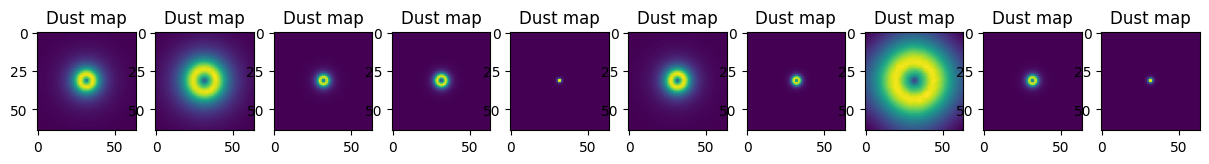

In [43]:
if is_notebook():

    nb_axs = 0
    if "Dust Map" in x[0]: nb_axs += 1
    if "CO Cube" in x[0]: nb_axs += 1
    if "N2H Cube" in x[0]: nb_axs += 1

    fig, axs = plt.subplots(nb_axs, 10, figsize=(15, 5))
    if nb_axs == 1: axs = np.array([axs])

    for i in range(10):
        vec = np.random.randint(0, len(x)+1)
        nb_axis = 0
        if "Dust Map" in x[0]:
            axs[nb_axis, i].imshow(x[vec]["Dust Map"])
            axs[nb_axis, i].set_title("Dust map")
            nb_axis += 1
        if "CO Cube" in x[0]:
            axs[nb_axis, i].imshow(np.sum(x[vec]["CO Cube"], axis=(-1,-2)))
            axs[nb_axis, i].set_title(f"CO map")
            nb_axis += 1
        if "N2H Cube" in x[0]:
            axs[nb_axis, i].imshow(np.sum(x[vec]["N2H Cube"], axis=(-1,-2)))
            axs[nb_axis, i].set_title(f"N2H+ map")
            nb_axis += 1

---

<div align=center>

# **Post processing**

</div>

### Normalisation

In [46]:
def normalize(x):

    # Set starting values

    x_maxs = copy(x[0])
    for key in x_maxs.keys():
        x_maxs[key] = np.max(x[0][key])

    # Increase value to the maximum encountered

    for vector in x:
        for key in vector.keys():
            if (value := np.max(np.abs(vector[key]))) > x_maxs[key]:
                x_maxs[key] = value

    # Normalize all vectors elements

    for i in range(len(x)):
        for key in vector.keys():
            x[i][key] /= x_maxs[key]

    return x_maxs

x_maxs = normalize(x)
y_maxs = normalize(y)

In [45]:
print("Maximum values:")
pd.DataFrame.from_records([x_maxs | y_maxs, ])

Maximum values:


,Dust Map,Mass
0,1154.924316,2.103129e+06


### Splitting datasets
#### Train

In [47]:
train_frac = 1 - valid_frac - test_frac

train_x = x[:int(nb_vectors * train_frac)]
train_y = y[:int(nb_vectors * train_frac)]

print(f"Train set: {len(train_x)} vectors")

Train set: 700 vectors


#### Validation

In [48]:
valid_x = x[int(nb_vectors * train_frac):int(nb_vectors * (train_frac + valid_frac))]
valid_y = y[int(nb_vectors * train_frac):int(nb_vectors * (train_frac + valid_frac))]

print(f"Valid set: {len(valid_x)} vectors")

Valid set: 200 vectors


#### Test

In [49]:
test_x = x[int(nb_vectors * (train_frac + valid_frac)):]
test_y = y[int(nb_vectors * (train_frac + valid_frac)):]

print(f"Test set: {len(test_x)} vectors")

Test set: 100 vectors


---

<div align=center>

# **Model definition**

</div>

### Build model

In [50]:
def get_model(sample):
    from keras.layers import Input, Dense, Conv2D, MaxPooling2D, MaxPooling3D, UpSampling2D, UpSampling3D, Reshape, Conv3DTranspose, Flatten
    from keras.models import Model

    inputs = {}
    for key, value in sample.items():
        print(key, *value.shape)
        inputs.update({key: Input(shape=value.shape, name=key)})

    # Encoder
    # x = Conv2D(8, (5, 5), activation='relu', padding='same')(input)
    # x = MaxPooling2D((4, 4), padding='same')(x)
    # x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    # x = MaxPooling2D((4, 4), padding='same')(x)
    # x = Flatten()(x)
    # x = Dense(1024, activation='relu')(x)

    x = Flatten()(inputs["Dust Map"])

    print(x.shape)

    x = Dense(128, activation='relu')(x)
    total_mass = Dense(1, activation='relu')(x)

    # x = Flatten()(dust_map)
    # x = Dense(128, activation='relu')(x)
    # max_temperature = Dense(1, activation='relu')(x)

    outputs = {
        "Mass" : total_mass,
    }

    # Modèle d'auto-encodeur
    model = Model(inputs, outputs)

    return model

### Compile model and get summary

In [52]:
model = get_model(x[0])

def tf_pearson(y_true, y_pred):
    return tf.contrib.metrics.streaming_pearson_correlation(y_pred, y_true)[1]

model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mean_squared_error'])

# Store and print model summary
stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
print(short_model_summary)

Dust Map 64 64 1
(None, 4096)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dust Map (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 128)               524416    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 524,545
Trainable params: 524,545
Non-trainable params: 0
_________________________________________________________________


### Human validation of the model

In [ ]:
# choice = input("Continue ? [Y/n]")

# if choice.lower() not in ["", "y", "yes"]:
#     exit()

In [55]:
def to_dict_of_list(lst):
    return {key: [dic[key] for dic in lst] for key in lst[0].keys()}

### Training model

In [56]:
epochs = 10000

bar = progress.Bar(epochs)
bar(0)
stage=0

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        global bar
        bar(epoch, prefix = f"MSE: {logs['mean_squared_error']:.2e}")


history = model.fit(to_dict_of_list(train_x), to_dict_of_list(train_y), epochs=10000, batch_size=50, validation_data=(to_dict_of_list(valid_x), to_dict_of_list(valid_y)), verbose=0, callbacks=[CustomCallback()],
                    workers=10, use_multiprocessing=True)
model.save(f'{archive_path}/model0.h5')
bar(epochs)

IndexError: tuple index out of range

In [ ]:
plt.plot(history.history['mean_squared_error'], alpha=0.5)
plt.plot(history.history['val_mean_squared_error'], alpha=0.5)
plt.title('Model MSE')
plt.ylabel('Mean square error')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


In [ ]:
plt.plot(history.history['loss'], alpha=0.5)
plt.plot(history.history['val_loss'], alpha=0.5)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'], alpha=0.5)
plt.plot(history.history['val_loss'], alpha=0.5)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.xscale('log')
plt.yscale('log')
plt.show()

### Evaluating model

In [ ]:
score = model.evaluate(test_x, test_y, verbose=0)
print("Score:", score)

with open(f'{archive_path}/scores.txt', 'w') as f:
    f.write(f'Score:    \t{score}\n')

---

<div align=center>

# **Predictions**

</div>

In [ ]:
r = np.random.randint(0, len(x)+1)
x_prediction = np.array([x[r]])
print(x_prediction.shape)

y_prediction = model.predict(x_prediction)[0,0]
print(y_prediction.shape)

print(f"Expected: {y[r] * y_maxs[0]:.2e} Msun")
print(f"Predicted: {y_prediction * y_maxs[0]:.2e} Msun")

np.savez_compressed(f'{archive_path}/prediction.npz', x=x_prediction, y=y_prediction)